<a href="https://colab.research.google.com/github/Ele975/LLM_from_scratch/blob/main/LLM_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import data

In [23]:
# for tokenizer
!pip install tiktoken

# for weights loading
!pip install tensorflow>=2.15.0
!pip install tqdm>=4.66

In [24]:
import re
import urllib.request
import tiktoken
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import zipfile
import os
import pandas as pd
import torch
import time
import json

from torch.utils.data import Dataset
from functools import partial
from pathlib import Path
from matplotlib.ticker import MaxNLocator
from torch.utils.data import Dataset, DataLoader

Download small dataset for training

In [25]:
url = ("https://raw.githubusercontent.com/rasbt/"
        "LLMs-from-scratch/main/ch02/01_main-chapter-code/"
        "the-verdict.txt")

file_path = "the-verdict.txt"
urllib.request.urlretrieve(url, file_path)

('the-verdict.txt', <http.client.HTTPMessage at 0x7e0408e094e0>)

In [26]:
with open("the-verdict.txt", "r", encoding="utf-8") as f:
  raw_text = f.read()
print('Total number of chars:', len(raw_text))
print(raw_text[:99])

Total number of chars: 20479
I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 


# Preprocessing

## Text tokenization (manual implementation not necessary for the code, theoretical explanation)

In [27]:
preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', raw_text)
# remove white spaces
preprocessed = [item.strip() for item in preprocessed if item.strip()]
print(preprocessed[:30])


['I', 'HAD', 'always', 'thought', 'Jack', 'Gisburn', 'rather', 'a', 'cheap', 'genius', '--', 'though', 'a', 'good', 'fellow', 'enough', '--', 'so', 'it', 'was', 'no', 'great', 'surprise', 'to', 'me', 'to', 'hear', 'that', ',', 'in']


## Vocabulary creation (manual implementation not necessary for the code, theoretical explanation)

In [28]:
# generate ordered set of unique tokens
all_words = sorted(set(preprocessed))
# add token for unkown words (not in the vocab) and for termination of documents when concatenation (inputs are concatenated and model should distinguish them)
all_words.extend(["<|endoftext|>", "<|unk|>"])
print(len(all_words))
print(all_words[:30])
print(all_words[-5:])


1132
['!', '"', "'", '(', ')', ',', '--', '.', ':', ';', '?', 'A', 'Ah', 'Among', 'And', 'Are', 'Arrt', 'As', 'At', 'Be', 'Begin', 'Burlington', 'But', 'By', 'Carlo', 'Chicago', 'Claude', 'Come', 'Croft', 'Destroyed']
['younger', 'your', 'yourself', '<|endoftext|>', '<|unk|>']


In [29]:
# generate vocabulary
vocab = {token:integer for integer, token in enumerate(all_words)}
for i, item in enumerate(vocab.items()):
  if i < 50:
    print(item)
  else:
    break

('!', 0)
('"', 1)
("'", 2)
('(', 3)
(')', 4)
(',', 5)
('--', 6)
('.', 7)
(':', 8)
(';', 9)
('?', 10)
('A', 11)
('Ah', 12)
('Among', 13)
('And', 14)
('Are', 15)
('Arrt', 16)
('As', 17)
('At', 18)
('Be', 19)
('Begin', 20)
('Burlington', 21)
('But', 22)
('By', 23)
('Carlo', 24)
('Chicago', 25)
('Claude', 26)
('Come', 27)
('Croft', 28)
('Destroyed', 29)
('Devonshire', 30)
('Don', 31)
('Dubarry', 32)
('Emperors', 33)
('Florence', 34)
('For', 35)
('Gallery', 36)
('Gideon', 37)
('Gisburn', 38)
('Gisburns', 39)
('Grafton', 40)
('Greek', 41)
('Grindle', 42)
('Grindles', 43)
('HAD', 44)
('Had', 45)
('Hang', 46)
('Has', 47)
('He', 48)
('Her', 49)


Class to convert from token to ID and vice-versa

In [30]:
class SimpleTokenizerV2:
  def __init__(self, vocab):
    self.str_to_int = vocab
    # inverse vocabulary permitting to map from int to token
    self.int_to_str = {integer:token for token, integer in vocab.items()}

  def encode(self, text):
    preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', text)
    preprocessed = [item.strip() for item in preprocessed if item.strip()]
    # unkown tag if token not in vocab
    preprocessed = [item if item in self.str_to_int else "<|unk|>" for item in preprocessed]
    ids = [self.str_to_int[s] for s in preprocessed]
    return ids

  def decode(self, ids):
    text = " ".join([self.int_to_str[i] for i in ids])
    # remove unnecessary spaces
    text = re.sub(r'\s+([,.?!"()\'])', r'\1', text)
    return text

Usage example

In [31]:
# tokenizer = SimpleTokenizerV1(vocab)
# text = """"It's the last he painted, you know,"
#        Mrs. Gisburn said with pardonable pride."""

# ids = tokenizer.encode(text)
# print(ids)

# print(tokenizer.decode(ids))
text1 = "Hello, do you like tea?"
text2 = "In the sunlit terraces of the palace."
text = " <|endoftext|> ".join((text1, text2))
print(text)

tokenizer = SimpleTokenizerV2(vocab)
print(tokenizer.encode(text))
print(tokenizer.decode(tokenizer.encode(text)))


Hello, do you like tea? <|endoftext|> In the sunlit terraces of the palace.
[1131, 5, 355, 1126, 628, 975, 10, 1130, 55, 988, 956, 984, 722, 988, 1131, 7]
<|unk|>, do you like tea? <|endoftext|> In the sunlit terraces of the <|unk|>.


## Dataset class and dataloader (manual implementation not necessary for the code, theoretical explanation)
Through sliding window with parameters as context size (length) and stride

BPE tokenizer already implemented (instead of the basic ones implemented above)

In [32]:
tokenizer = tiktoken.get_encoding("gpt2")

In [33]:
with open("the-verdict.txt", "r", encoding="utf-8") as f:
  raw_text = f.read()

enc_text = tokenizer.encode(raw_text)
print(len(enc_text))

5145


In [34]:
enc_sample = enc_text[:50]

In [35]:
# elements in the input (window' size)
context_size = 4

dataset class -> each element in the dataset is a sequence of tokens, generating a dataset of successive strings. These sequences have a gap between each other of value 'stride'.

In [36]:
class GPTDatasetV1(Dataset):
  def __init__(self, txt, tokenizer, max_length, stride):
    self.input_ids = []
    self.target_ids = []

    token_ids = tokenizer.encode(txt)

    for i in range(0, len(token_ids) - max_length, stride):
      input_chunk = token_ids[i:i+max_length]
      target_chunk = token_ids[i+1:i+1+max_length]
      self.input_ids.append(torch.tensor(input_chunk))
      self.target_ids.append(torch.tensor(target_chunk))

  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.target_ids[idx]


Dataloader -> contains input batch and target batch because of the implementation of GPTDatasetV1 that generate the input ids and target ids

In [37]:
def create_dataloader_v1(txt, batch_size=4, max_length=256, stride=128, shuffle=True, drop_last=True, num_workers=0):
  tokenizer = tiktoken.get_encoding("gpt2")
  dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)
  dataloader = DataLoader(
      dataset,
      batch_size = batch_size,
      shuffle = shuffle,
      drop_last = drop_last,
      num_workers = num_workers
  )

  return dataloader

Print first batch example

In [38]:
with open("the-verdict.txt", "r", encoding="utf-8") as f:
  raw_text = f.read()
dataloader = create_dataloader_v1(raw_text, batch_size=1, max_length=4, stride=1, shuffle=False)
data_iter = iter(dataloader)
first_batch = next(data_iter)
print(first_batch)

[tensor([[  40,  367, 2885, 1464]]), tensor([[ 367, 2885, 1464, 1807]])]


## Token embedding (manual implementation not necessary for the code, theoretical explanation)
Transform tokens IDs into embedding vectors (embedding can be optimized). Necessary since vectors are a continuous representation and neural networks use backward propagation for training. The embedding layer has dimension (vocab_size x embedding_dim), since for each word in the vocabulary we'll have an embedding vector of size embedding_dim. This embedding matrix is optimized during the training of the model as part of the training itself. Given then the token ID, it is possible to retrieve from the embedding matrix the embedding vector for that specific token.

In [39]:
# size vocabulary BPE tokenizer
vocab_size = 50257
output_dim = 256

token_embedding_layer = torch.nn.Embedding(vocab_size, output_dim)

Instantiate data loader

In [40]:
max_length = 4
dataloader = create_dataloader_v1(
    raw_text, batch_size=8, max_length=max_length,
   stride=max_length, shuffle=False
)
data_iter = iter(dataloader)
inputs, targets = next(data_iter)
print("Token IDs:\n", inputs)
print("\nInputs shape:\n", inputs.shape)

# use embedding layer to embed the tokens inside the first batch
# retrieve embedding vectors given IDs
token_embeddings = token_embedding_layer(inputs)
print(token_embeddings.shape)

Token IDs:
 tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])

Inputs shape:
 torch.Size([8, 4])
torch.Size([8, 4, 256])


Add absolute embedding approach

In [41]:
context_length = max_length

pos_embedding_layer = torch.nn.Embedding(context_length, output_dim)
# indices for positions 0,1,2 .. context_length - 1, i.e. 0, 1, 2 .. context_length - 1
# retrieve embedding vectors given IDs
pos_embeddings = pos_embedding_layer(torch.arange(context_length))
print(pos_embeddings.shape)


torch.Size([4, 256])


Add positional embeddings to basic embeddings = input embedding

In [42]:
input_embeddings = token_embeddings + pos_embeddings

# Attention mechanism

## 1. Simplified version (not necessary for the code, theoretical explanation)

Embedding vectors of 'Your journey starts with one step'

In [43]:
inputs = torch.tensor(
  [[0.43, 0.15, 0.89], # Your     (x^1)
   [0.55, 0.87, 0.66], # journey  (x^2)
[0.57, 0.85, 0.64], # starts
[0.22, 0.58, 0.33], # with
[0.77, 0.25, 0.10], # one
[0.05, 0.80, 0.55]] # step
)


Computation attention score for a specific embedding vector (token) with respect to all the others -> dot product between selected token (embedded query token) and all the other embedding vectors

In [44]:
# computing all attention score for all inputs, i.e. 6 values for each input
attn_scores = inputs @ inputs.T
print(attn_scores)


tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])


normalized attention scores, i.e. AS[2]/tot(AS) or with Softmax (more used since better managing of extreme values)

In [45]:
attn_weights = torch.softmax(attn_scores, dim=-1)
print("Attention weights:", attn_weights)
print('All row sums:', attn_weights.sum(dim=-1))

Attention weights: tensor([[0.2098, 0.2006, 0.1981, 0.1242, 0.1220, 0.1452],
        [0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581],
        [0.1390, 0.2369, 0.2326, 0.1242, 0.1108, 0.1565],
        [0.1435, 0.2074, 0.2046, 0.1462, 0.1263, 0.1720],
        [0.1526, 0.1958, 0.1975, 0.1367, 0.1879, 0.1295],
        [0.1385, 0.2184, 0.2128, 0.1420, 0.0988, 0.1896]])
All row sums: tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])


Attention weights: sum of all input embedding multiplied with their attention score

In [46]:
all_context_vecs = attn_weights @ inputs
print(all_context_vecs)

tensor([[0.4421, 0.5931, 0.5790],
        [0.4419, 0.6515, 0.5683],
        [0.4431, 0.6496, 0.5671],
        [0.4304, 0.6298, 0.5510],
        [0.4671, 0.5910, 0.5266],
        [0.4177, 0.6503, 0.5645]])


## 2. Self-attention (with trainable parameters) (not necessary for the code, theoretical explanation)

In [47]:
x_2 = inputs[1]
d_in = inputs.shape[1]
d_out = 2

Matrices (query, key, value)

In [48]:
torch.manual_seed(123)
# requires_grad should be true if we really use them since they must be updated during training
W_query = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_key = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_value = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)


In [49]:
# pytorch translate automatically x_2 to adjust the dimensions
query_2 = x_2 @ W_query
key_2 = x_2 @ W_key
value_2 = x_2 @ W_value
print(query_2)

tensor([0.4306, 1.4551])


Get all keys and values for all input

In [50]:
keys = inputs @ W_key
values = inputs @ W_value
print("keys.shape:", keys.shape)
print("values.shape:", values.shape)

keys.shape: torch.Size([6, 2])
values.shape: torch.Size([6, 2])


Attention score: dot product between query vector and key vector, i.e. attention score 2_2: query2.key2

In [51]:
keys_2 = keys[1]
attn_score_22 = query_2.dot(keys_2)
print(attn_score_22)

tensor(1.8524)


Attention score of all inputs with respect to input 2 (i.e. using query 2)

In [52]:
attn_scores_2 = query_2 @ keys.T
print(attn_scores_2)

tensor([1.2705, 1.8524, 1.8111, 1.0795, 0.5577, 1.5440])


Attention weights -> normalization and softmax -> divide attention scores by dividing them by the square root of the embedding dimension of the keys

In [53]:
d_k = keys.shape[-1]
attn_weights_2 = torch.softmax(attn_scores_2/d_k**0.5, dim=-1)
print(attn_weights_2)

tensor([0.1500, 0.2264, 0.2199, 0.1311, 0.0906, 0.1820])


Context vector for input 2 -> weighted sum over the value vectors

In [54]:
context_vec_2 = attn_weights_2 @ values
print(context_vec_2)

tensor([0.3061, 0.8210])


Compact implementation using Python class for each input

In [55]:
class SelfAttention_V1(nn.Module):
  def __init__(self, d_in, d_out, qkv_bias=False):
    # call superclass init since internal initialization logic should be executed for nn.Module
    super().__init__()
    # nn.Linear has optimized weight initialization scheme
    self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)

  # x = all inputs
  def forward(self, x):
    keys = self.W_key(x)
    values = self.W_value(x)
    queries = self.W_query(x)

    attn_scores = queries @ keys.T
    attn_weights = torch.softmax(attn_scores/keys.shape[-1]**0.5, dim=-1)
    context_vec = attn_weights @ values
    return context_vec

How to use it (example)

In [56]:
torch.manual_seed(789)
sa_v1 = SelfAttention_V1(d_in, d_out)
# returns the context vectors
print(sa_v1(inputs))

tensor([[-0.0739,  0.0713],
        [-0.0748,  0.0703],
        [-0.0749,  0.0702],
        [-0.0760,  0.0685],
        [-0.0763,  0.0679],
        [-0.0754,  0.0693]], grad_fn=<MmBackward0>)


## 3. Causal attention (not necessary for the code, theoretical explanation)
Set to 0 all attention weights associated with the tokens after the selected one (lower triangular matrix)

In [57]:
queries = sa_v1.W_query(inputs)
keys = sa_v1.W_key(inputs)
attn_scores = queries @ keys.T
attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
print(attn_weights)

tensor([[0.1921, 0.1646, 0.1652, 0.1550, 0.1721, 0.1510],
        [0.2041, 0.1659, 0.1662, 0.1496, 0.1665, 0.1477],
        [0.2036, 0.1659, 0.1662, 0.1498, 0.1664, 0.1480],
        [0.1869, 0.1667, 0.1668, 0.1571, 0.1661, 0.1564],
        [0.1830, 0.1669, 0.1670, 0.1588, 0.1658, 0.1585],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<SoftmaxBackward0>)


Create lower triangular matrix

In [58]:
context_length = attn_weights.shape[0]
mask_simple = torch.tril(torch.ones(context_length, context_length))
print(mask_simple)

tensor([[1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1.]])


Insert attention weights values

In [59]:
masked_simple = attn_weights * mask_simple
print(masked_simple)

tensor([[0.1921, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2041, 0.1659, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2036, 0.1659, 0.1662, 0.0000, 0.0000, 0.0000],
        [0.1869, 0.1667, 0.1668, 0.1571, 0.0000, 0.0000],
        [0.1830, 0.1669, 0.1670, 0.1588, 0.1658, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<MulBackward0>)


Renormalize values to have sum = 1 for each row (divide each row values for the sum in each row)

In [60]:
row_sums = masked_simple.sum(dim=-1, keepdim=True)
masked_simple_norm = masked_simple / row_sums

print(masked_simple_norm)


tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5517, 0.4483, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3800, 0.3097, 0.3103, 0.0000, 0.0000, 0.0000],
        [0.2758, 0.2460, 0.2462, 0.2319, 0.0000, 0.0000],
        [0.2175, 0.1983, 0.1984, 0.1888, 0.1971, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<DivBackward0>)


Set 0s values to -inf -> softmax treat them as 0 probability -> more efficient masking trick

In [61]:
# diagonal = 1 -> start from the diagonal above the middle one
mask = torch.triu(torch.ones(context_length, context_length), diagonal=1)
# put -inf to all values above lower triangular
masked = attn_scores.masked_fill(mask.bool(), -torch.inf)
print(masked)

tensor([[0.2899,   -inf,   -inf,   -inf,   -inf,   -inf],
        [0.4656, 0.1723,   -inf,   -inf,   -inf,   -inf],
        [0.4594, 0.1703, 0.1731,   -inf,   -inf,   -inf],
        [0.2642, 0.1024, 0.1036, 0.0186,   -inf,   -inf],
        [0.2183, 0.0874, 0.0882, 0.0177, 0.0786,   -inf],
        [0.3408, 0.1270, 0.1290, 0.0198, 0.1290, 0.0078]],
       grad_fn=<MaskedFillBackward0>)


Softmax for normalization

In [62]:
attn_weights = torch.softmax(masked / keys.shape[-1]**0.5, dim=1)
print(attn_weights)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5517, 0.4483, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3800, 0.3097, 0.3103, 0.0000, 0.0000, 0.0000],
        [0.2758, 0.2460, 0.2462, 0.2319, 0.0000, 0.0000],
        [0.2175, 0.1983, 0.1984, 0.1888, 0.1971, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<SoftmaxBackward0>)


Implement dropout layer to avoid overfitting

In [63]:
torch.manual_seed(123)
# in general dropout used: 0.2/0.3
dropout = torch.nn.Dropout(0.5)
print(dropout(attn_weights))

tensor([[2.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.8966, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.6206, 0.0000, 0.0000, 0.0000],
        [0.5517, 0.4921, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4350, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.3327, 0.0000, 0.0000, 0.0000, 0.0000]],
       grad_fn=<MulBackward0>)


Add an input of 6 tokens, for a total of 2 inputs

In [64]:
batch = torch.stack((inputs, inputs), dim=0)
print(batch.shape)
print(batch)

torch.Size([2, 6, 3])
tensor([[[0.4300, 0.1500, 0.8900],
         [0.5500, 0.8700, 0.6600],
         [0.5700, 0.8500, 0.6400],
         [0.2200, 0.5800, 0.3300],
         [0.7700, 0.2500, 0.1000],
         [0.0500, 0.8000, 0.5500]],

        [[0.4300, 0.1500, 0.8900],
         [0.5500, 0.8700, 0.6600],
         [0.5700, 0.8500, 0.6400],
         [0.2200, 0.5800, 0.3300],
         [0.7700, 0.2500, 0.1000],
         [0.0500, 0.8000, 0.5500]]])


Self attention class with causal mask component and dropout

In [65]:
class CausalAttention(nn.Module):
  def __init__(self, d_in, d_out, context_length, dropout, qkv_bias=False):
    super().__init__()
    self.d_out = d_out
    self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.W_key   = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.dropout = nn.Dropout(dropout)

    # mask has size context_length x context_length since we need to store the attention scores and attention weights for each token before the current one (lower triangular matrix)
    self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length, diagonal=1)))

  def forward(self, x):
    b, num_tokens, d_in = x.shape
    keys = self.W_key(x)
    values = self.W_value(x)
    queries = self.W_query(x)

    # transpose last two dimensions of keys to enable matrix multiplication -> from (batch_size, tokens_nr, embedding_dim) to (batch_size, embedding_dim, )
    attn_scores = queries @ keys.transpose(1,2)
    # access the mask above saved as buffer -> not optimized during backpropagation but available during the forward pass (often with masks)
    attn_scores.masked_fill(self.mask.bool()[:num_tokens, :num_tokens], -torch.inf)
    attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
    attn_weights = self.dropout(attn_weights)
    context_vec = attn_weights @ values
    return context_vec





## 4. Multi-head attention
Multiple queries, keys and values in parallel permits to compute different attention weights and attention scores. The resulting context vectors are then concatenated.

In [66]:
class MultiHeadAttentionWrapper(nn.Module):
  def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
    super().__init__()
    # create the desired number of heads using the class above that generates a single causal attention head
    self.heads = nn.ModuleList([CausalAttention(d_in, d_out, context_length, dropout, qkv_bias) for _ in range(num_heads)])

  def forward(self, x):
    # head(x) call the forward method of the class CausalAttention and returns the context vectors for a single head
    return torch.cat([head(x) for head in self.heads], dim=-1)

In [67]:
class MultiHeadAttention(nn.Module):
  def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
    super().__init__()
    # the inputs are multiplied by the matrices Q,K,V generating the reduced q,v,k which have the same dimension of the output context vector.
    # For the parallel computation, q,v,k are split across the multiple heads, thus the dimension of q,v,k should be at least # heads
    assert (d_out % num_heads == 0), "d_out must be divisible by num_heads"
    self.d_out = d_out
    self.num_heads = num_heads
    self.head_dim = d_out // num_heads
    self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.dropout = nn.Dropout(dropout)
    self.out_proj = nn.Linear(d_out, d_out)

    self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1))

  def forward(self, x):
    b, num_tokens, d_in = x.shape
    keys = self.W_key(x)
    queries = self.W_query(x)
    values = self.W_value(x)

    # view = reshape from [b, num_tokens, d_in] to [b, num_tokens, self.num_heads, self.head_dim] -> dimensions of k,q,v for each head
    keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
    queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)
    values = values.view(b, num_tokens, self.num_heads, self.head_dim)

    # transpose in order to compute separately the results for each head, pass from [b, num_tokens, self.num_heads, self.head_dim] to [b, num_tokens, self.head_dim, self.num_heads]
    keys = keys.transpose(1, 2)
    queries = queries.transpose(1, 2)
    values = values.transpose(1, 2)

    attn_scores = queries @ keys.transpose(2,3)
    # not always context_sizes correspond to num_tokens (last batch, last input can have less tokens), thus cut
    mask_bool = self.mask.bool()[:num_tokens, :num_tokens]
    attn_scores.masked_fill_(mask_bool, -torch.inf)

    attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
    attn_weights = self.dropout(attn_weights)

    # transpose again to pass from [b, num_tokens, self.head_dim, self.num_heads] to [b, self.head_dim, num_tokens, self.num_heads]
    # permit to concanenate easier the results of the different heads
    context_vec = (attn_weights @ values).transpose(1, 2)

    # combine head results
    context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)

    # raw concatenation is not enough for the models, thus this is used to refine the concatenation. Not mandatory but commonly used
    context_vec = self.out_proj(context_vec)
    return context_vec


In [68]:
torch.manual_seed(123)
batch_size, context_length, d_in = batch.shape
d_out = 2
mha = MultiHeadAttention(d_in, d_out, context_length, 0.0, num_heads=2)
context_vecs = mha(batch)
print(context_vecs)
print("context_vecs.shape:", context_vecs.shape)

tensor([[[0.3190, 0.4858],
         [0.2943, 0.3897],
         [0.2856, 0.3593],
         [0.2693, 0.3873],
         [0.2639, 0.3928],
         [0.2575, 0.4028]],

        [[0.3190, 0.4858],
         [0.2943, 0.3897],
         [0.2856, 0.3593],
         [0.2693, 0.3873],
         [0.2639, 0.3928],
         [0.2575, 0.4028]]], grad_fn=<ViewBackward0>)
context_vecs.shape: torch.Size([2, 6, 2])


# LLM model (GPT-like model)

In [69]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "emb_dim": 768,   # Embedding dimension
    "n_heads": 12,  # Number of attention heads
    "n_layers": 12,  # Number of layers
    "drop_rate": 0.1,  # Dropout rate
    "qkv_bias": False # Query-Key-Value bias
}

GPT dummy model

In [70]:
class DummyGPTModel(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
    self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
    self.drop_emb = nn.Dropout(cfg["drop_rate"])
    # For now use DummyTransformerBlockas placeholder for actual transformer layers
    self.trf_blocks = nn.Sequential(*[DummyTransformerBlock(cfg)for _ in range(cfg["n_layers"])])

    # for now placeholder as normal layer
    self.final_norm = DummyLayerNorm(cfg["emb_dim"])
    # map embedding layer vocab_size x emb_dim into output layer emb_dim x vocab_size, such emb_dim is projected to vocab dimension, and applying a sofmax we can get the
    # next work that is the one with the highest probability
    self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)

  def forward(self, in_idx):
    batch_size, seq_len = in_idx.shape
    # lookup in the tok_emb for the indices given in in_idx
    tok_embeds = self.tok_emb(in_idx)
    # seq_len = context_len
    pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
    x = tok_embeds + pos_embeds
    x = self.drop_emb(x)
    x = self.trf_blocks(x)
    x = self.final_norm(x)
    # final results
    logits = self.out_head(x)
    return logits

Transformer blocks not implemented yet

In [71]:
class DummyTransformerBlock(nn.Module):
  def __init__(self, cfg):
    super().__init__()

  def forward(self, x):
    return x

Normalization not implemented yet

In [72]:
class DummyLayerNorm(nn.Module):
  def __init__(self, normalized_shape, eps=1e-5):
    super().__init__()

  def forward(self, x):
    return x

In [73]:
tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"
batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
print(batch)
batch = torch.stack(batch, dim=0)
print(batch)

[tensor([6109, 3626, 6100,  345]), tensor([6109, 1110, 6622,  257])]
tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [74]:
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)
logits = model(batch)
# each token has embedding size of 50'257 because is the number of tokens in the vocab, then we'll use a softmax to know which token with highest probability will be the next
print("Output shape:", logits.shape)
print(logits)

Output shape: torch.Size([2, 4, 50257])
tensor([[[-0.9289,  0.2748, -0.7557,  ..., -1.6070,  0.2702, -0.5888],
         [-0.4476,  0.1726,  0.5354,  ..., -0.3932,  1.5285,  0.8557],
         [ 0.5680,  1.6053, -0.2155,  ...,  1.1624,  0.1380,  0.7425],
         [ 0.0447,  2.4787, -0.8843,  ...,  1.3219, -0.0864, -0.5856]],

        [[-1.5474, -0.0542, -1.0571,  ..., -1.8061, -0.4494, -0.6747],
         [-0.8422,  0.8243, -0.1098,  ..., -0.1434,  0.2079,  1.2046],
         [ 0.1355,  1.1858, -0.1453,  ...,  0.0869, -0.1590,  0.1552],
         [ 0.1666, -0.8138,  0.2307,  ...,  2.5035, -0.3055, -0.3083]]],
       grad_fn=<UnsafeViewBackward0>)


## 1. Normalization layer
Used to avoid explosion or vanishing of the gradient through standard deviation (subtract the mean and divide by square root of variance)

In [75]:
class LayerNorm(nn.Module):
  def __init__(self, emb_dim):
    super().__init__()
    self.eps = 1e-5
    self.scale = nn.Parameter(torch.ones(emb_dim))
    self.shift = nn.Parameter(torch.zeros(emb_dim))

  def forward(self, x):
      mean = x.mean(dim=-1, keepdim=True)
      var = x.var(dim=-1, keepdim=True, unbiased=False)
      norm_x = (x - mean) / torch.sqrt(var + self.eps)
      return self.scale * norm_x + self.shift

## 2. FNN with GELU
GELU with respect to ReLu is better for optimization.
The FNN layer permits the model to generalize and learn better the data: despite the input and output dimension is the same, internally this dimension is expanded, which permit the exporation of a richer representation space.

In [76]:
class GELU(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, x):
    return 0.5 * x * (1 + torch.tanh(torch.sqrt(torch.tensor(2.0 / torch.pi)) * (x + 0.044715 * torch.pow(x, 3))))

In [77]:
class FeedForward(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.layers = nn.Sequential(nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
                                GELU(),
                                nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),)

  def forward(self, x):
    return self.layers(x)

## 3. Shortcut connections
Added between different layers to improve training performance, since they avoid gradient vanishing by skipping some layers. How? Adding inpute values to the output of certain layers

In [78]:
target = torch.tensor([[0.]])
print(target)

tensor([[0.]])


In [79]:
class ExampleDeepNeuralNetwork(nn.Module):
  def __init__(self, layer_sizes, use_shortcut):
    super().__init__()
    self.use_shortcut = use_shortcut
    self.layers = nn.ModuleList([
      nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), GELU()),
      nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), GELU()),
      nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), GELU()),
      nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), GELU()),
      nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), GELU())
    ])

  def forward(self, x):
    for layer in self.layers:
      layer_output = layer(x)
      if self.use_shortcut and x.shape == layer_output.shape:
        x = x + layer_output
      else:
        x = layer_output
    return x

In [80]:
layer_sizes = [3, 3, 3, 3, 3, 1]
sample_input = torch.tensor([[1., 0., -1.]])
torch.manual_seed(123)
model_without_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=True
)

In [81]:
def print_gradients(model, x):
  output = model(x)
  target = torch.tensor([[0.]])
  loss = nn.MSELoss()
  loss = loss(output, target)
  loss.backward()
  for name, param in model.named_parameters():
    if 'weight' in name:
      print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

In [82]:
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.22169791162014008
layers.1.0.weight has gradient mean of 0.20694105327129364
layers.2.0.weight has gradient mean of 0.32896995544433594
layers.3.0.weight has gradient mean of 0.2665732204914093
layers.4.0.weight has gradient mean of 1.3258540630340576


## 4. Transformer block
Composed by multi-head attention, layer normalization, dropout, feed forward layers, GELU activation function

In [83]:
class TransformerBlock(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.att = MultiHeadAttention(
        d_in=cfg["emb_dim"],
        d_out=cfg["emb_dim"],
        context_length=cfg["context_length"],
        num_heads=cfg["n_heads"],
        dropout=cfg["drop_rate"],
        qkv_bias=cfg["qkv_bias"]
    )
    self.ff = FeedForward(cfg)
    # normalize the embedding dimension
    self.norm1 = LayerNorm(cfg["emb_dim"])
    self.norm2 = LayerNorm(cfg["emb_dim"])
    self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

  def forward(self, x):
    # save input for attention shortcut
    shortcut = x
    x = self.norm1(x)
    x = self.att(x)
    x = self.drop_shortcut(x)
    x = x + shortcut

    # shortcut for FNN
    shortcut = x
    x = self.norm2(x)
    x = self.ff(x)
    x = self.drop_shortcut(x)
    x = x + shortcut

    return x



## GPT architecture class

In [84]:
class GPTModel(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
    self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
    self.drop_emb = nn.Dropout(cfg["drop_rate"])

    self.trf_blocks = nn.Sequential(
    *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])

    self.final_norm = LayerNorm(cfg["emb_dim"])
    self.out_head = nn.Linear(
        cfg["emb_dim"], cfg["vocab_size"], bias=False
    )

  def forward(self, in_idx):
    batch_size, seq_len = in_idx.shape
    tok_embeds = self.tok_emb(in_idx)
    pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
    x = tok_embeds + pos_embeds
    x = self.drop_emb(x)
    x = self.trf_blocks(x)
    x = self.final_norm(x)
    logits = self.out_head(x)
    return logits

Run model

In [85]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
out = model(batch)
print("Input batch:\n", batch)
print("\nOutput shape:", out.shape)
print(out)

Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Output shape: torch.Size([2, 4, 50257])
tensor([[[ 0.1381,  0.0077, -0.1963,  ..., -0.0222, -0.1060,  0.1717],
         [ 0.3865, -0.8408, -0.6564,  ..., -0.5163,  0.2369, -0.3357],
         [ 0.6989, -0.1829, -0.1631,  ...,  0.1472, -0.6504, -0.0056],
         [-0.4290,  0.1669, -0.1258,  ...,  1.1579,  0.5303, -0.5549]],

        [[ 0.1094, -0.2894, -0.1467,  ..., -0.0557,  0.2911, -0.2824],
         [ 0.0882, -0.3552, -0.3527,  ...,  1.2930,  0.0053,  0.1898],
         [ 0.6091,  0.4702, -0.4094,  ...,  0.7688,  0.3787, -0.1974],
         [-0.0612, -0.0737,  0.4751,  ...,  1.2463, -0.3834,  0.0609]]],
       grad_fn=<UnsafeViewBackward0>)


Compute total number of trainable/trained parameters

In [86]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 163,009,536


Generation of possibly multiple tokens, whose length depends on the user.Multiple iteration of the generation of a next token permit the model to generate meaninful complete sentences.

Approaches:
1. **softmax** -> the model returns everytime the token with the highest probability. The result is always the same every time the model is used.

2. **multinomial** -> the model returns most of the time the token with the highest probability, but not always. In this way, the originality of the output text is improved.

3. **temperature scaling** -> divide logitcs by a value greater than 0. Higher is the value of teh temperature, higher will be the originality. Too high values are not recommended (> 2/3), since we can have nonsensical output test

**top-k approach**: possibly used before temperature scaling or multinomial to avoid nonsensical text -> select top k tokens with highest probabilities after softmax, and set to -inf all other logits s.t. the resulting probability with the softmax is 0 for all the other tokens, then normalize to have all remaining probabilities summed up to 1 (automatically done using the softmax).


Simple version without text originality (used in the model traning)

In [87]:
# idx -> input with size (batch, token ids)
def generate_text_simple(model, idx, max_new_tokens, context_size):
  for _ in range(max_new_tokens):
    # crops current context size to supported context size by the model -> if model supports size 5 and context size is 10, maintain last 5 tokens as context
    idx_cond = idx[:, -context_size:]
    with torch.no_grad():
      logits = model(idx_cond)

    # output of model is (batch, token, vocab), thus take last token
    logits = logits[:, -1, :]

    # temperature scaling

    # temperature = 0.5
    # logits = logits/temperature

    probas = torch.softmax(logits, dim=-1)

    # get idx of the next token that will be part of the next input given to the model
    idx_next = torch.argmax(probas, dim=-1, keepdim=True)
    # multinomial option -> take one sample and convert to tensor
    # idx_text = torch.multinomial(probas, num_sample=1).item()

    idx = torch.cat((idx, idx_next), dim=1)
  return idx


Complete version with text originality (not used in the model training)

In [88]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):
  for _ in range(max_new_tokens):
    idx_cond = idx[:, -context_size:]
    with torch.no_grad():
      logits = model(idx_cond)
    logits = logits[:, -1, :]
    # choose if possible top k tokens
    if top_k is not None:
      top_logits, _ = torch.topk(logits, top_k)
      min_val = top_logits[:, -1]
      # set all other logits to -inf
      logits = torch.where(logits < min_val, torch.tensor(float('-inf')).to(logits.device),logits)

    if temperature > 0.0:
      logits = logits / temperature
      probs = torch.softmax(logits, dim=-1)
      idx_next = torch.multinomial(probs, num_samples=1)
    else:
      idx_next = torch.argmax(logits, dim=-1, keepdim=True)

    if idx_next == eos_id:
      break

    idx = torch.cat((idx, idx_next), dim=1)
  return idx


In [89]:
start_context = "Hello, I am"
encoded = tokenizer.encode(start_context)
# add batch dimension (instead of (4), we get (1,4))
encoded_tensor = torch.tensor(encoded).unsqueeze(0)

# put model in eval mode to remove layers used only for training (e.g. dropout layers)
model.eval()

out = generate_text_simple(
  model=model,
  idx=encoded_tensor,
  max_new_tokens=6,
  context_size=GPT_CONFIG_124M["context_length"]
)

print("Output:", out)
print("Output length:", len(out[0]))

Output: tensor([[15496,    11,   314,   716, 27018, 24086, 47843, 30961, 42348,  7267]])
Output length: 10


## Conversion from GPT output to token
The result of GPT model is a matrix. To get the predicted token, it is required to extract the last vector, apply the softmax to get probabilities, identify the index associated with the highest probability which is also the token ID, and get the token given its specific ID.

In [90]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)

Hello, I am Featureiman Byeswickattribute argue


# Pretraining

In [91]:
# shorter context_length
GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 256,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qkv_bias": False
}
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (dropout): Dropout(p=0.1, inplace=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

Functions to convert from tokens to tokens IDs and opposite

In [92]:
def text_to_token_ids(text, tokenizer):
  encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
  # insert batch dimension
  encoded_tensor = torch.tensor(encoded).unsqueeze(0)
  return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
  # remove batch dimension
  flat = token_ids.squeeze(0)
  return tokenizer.decode(flat.tolist())

Try functions

In [93]:
start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model = model,
    idx = text_to_token_ids(start_context, tokenizer),
    max_new_tokens = 10,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren


## Loss computation without training
Load small dataset 'The verdict' to save time

In [94]:
file_path = "the-verdict.txt"
with open(file_path, 'r', encoding='utf-8') as f:
  text_data = f.read()

get text length

In [95]:
total_chars = len(text_data)
total_tok = tokenizer.encode(text_data)
print("Total characters:", total_chars)
print("Total tokens:", len(total_tok))

Total characters: 20479
Total tokens: 5145


Split dataset into training set and validation set with ratio of 90% and 10%

In [96]:
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

Data loader -> contains for each element input batch and target batch

In [97]:
def create_dataloader_v1(txt, batch_size=4, max_length=256, stride=128, shuffle=True, drop_last=True, num_workers=0):
  tokenizer = tiktoken.get_encoding("gpt2")
  dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)
  dataloader = DataLoader(
      dataset,
      batch_size = batch_size,
      shuffle = shuffle,
      drop_last = drop_last,
      num_workers = num_workers
  )

  return dataloader

In [98]:
train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

In [99]:
val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

Compute loss function for a single batch

In [100]:
def calc_loss_batch(input_batch, target_batch, model, device):
  # transferring data to a device permit to transfer data to GPU
  input_batch = input_batch.to(device)
  target_batch = target_batch.to(device)
  logits = model(input_batch)
  # logits.flatten(0,1) -> merge dimensions 0 and 1 into a single one, from (batch_dim, nr_tokens, vocab_dim) to (batch_dim*nr_tokens, vocab_dim)
  loss = torch.nn.functional.cross_entropy(logits.flatten(0,1), target_batch.flatten())
  return loss


Compute loss for all batches of traning and validation set

In [101]:
def calc_loss_loader(data_loader, model, device, num_batches = None):
  total_loss = 0.
  if len(data_loader) == 0:
    return float("nan")
  # if num_batches not specified
  elif num_batches is None:
    # dataloader returns data grouped by batches
    num_batches = len(data_loader)
  else:
    num_batches = min(num_batches, len(data_loader))
  for i, (input_batch, target_batch) in enumerate(data_loader):
    if i < num_batches:
      loss = calc_loss_batch(input_batch, target_batch, model, device)
      # sum loss over batches
      total_loss += loss.item()
    else:
      break
  # average loss over all batches
  return total_loss/num_batches


Compute loss (high since no training performed yet)

In [102]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
with torch.no_grad():
  train_loss = calc_loss_loader(train_loader, model, device)
  val_loss = calc_loss_loader(val_loader, model, device)
print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 10.987583584255642
Validation loss: 10.98110580444336


## LLM Pretraining
traning:
1. iterate over each epoch (complete iteration over all input data)
2. iterate over each batch
3. reset loss gradients for each batch (batches are processed independently and their loss shouldn't be summed up).
4. compute loss on current batch (forward pass)
5. compute backpropagation (backward pass) to compute gradient of the loss with respect to the parameters (weights, biases)
6. update parameters based on the gradients get in the previous step
7. (print training and validation losses for tracking progress)

Evaluating the validation set within the training process permit to understand how the model perform on unseen data in order to use techniques to improve precision if needed (modify hyperparameter such as batch size, learning rate, etc. ) and can implement strategies such as early stopping to avoid a biased model on training data (overfitting). In addition spikes in validation data indicates issues in the training process

In [103]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs, eval_freq, eval_iter, start_context, tokenizer):
  # track losses and tokens seen
  train_losses, val_losses, track_tokens_seen = [], [], []
  # global_step initialized with -1 so that it can work as index
  tokens_seen, global_step = 0, -1

  for epoch in range(num_epochs):
    model.train()
    for input_batch, target_batch in train_loader:
      optimizer.zero_grad()
      loss = calc_loss_batch(input_batch, target_batch, model, device)
      # compute loss gradients
      loss.backward()
      # update model parameters depending on loss gradients
      optimizer.step()
      tokens_seen += input_batch.numel()
      global_step += 1

      # eval_freq is the frequency on which we evaluate the model on a validation or test set (if 5, each 5 batches we evaluate the model), optional to see improvements
      if global_step % eval_freq == 0:
        train_loss, val_loss = evaluate_model(model, train_loader, val_loader, device, eval_iter)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        track_tokens_seen.append(tokens_seen)

        print(f"Ep {epoch+1} (Step {global_step:06d}): "
              f"Train loss {train_loss:.3f}, "
              f"Val loss {val_loss:.3f}"
              )

    generate_and_print_sample(model, tokenizer, device, start_context)
  return train_losses, val_losses, track_tokens_seen




Evaluation: compute loss over training and evaluation sets ensuring model is in evaluation mode without dropout  

In [104]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
  model.eval()
  # not required in evaluation and save computational space
  with torch.no_grad():
    # compute loss for multiple batches to have more stable evaluation
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    # swap again to training mode for the training process in train_model_simple()
    model.train()
    return train_loss, val_loss

Evaluate the model by taking a text snippet and passing to the model

In [105]:
# start_context = text snippet for evaluation purposes
def generate_and_print_sample(model, tokenizer, device, start_context):
  model.eval()
  # in the positional embedding weights the first shape is the context size
  context_size = model.pos_emb.weight.shape[0]
  encoded = text_to_token_ids(start_context, tokenizer).to(device)
  with torch.no_grad():
    # use the model in order to get the predicted next tokens starting from start_context
    token_ids = generate_text_simple(model=model, idx=encoded,max_new_tokens=50, context_size=context_size)
  decoded_text = token_ids_to_text(token_ids, tokenizer)
  print(decoded_text.replace("\n", " "))
  model.train()

Train the model

In [106]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(
     model.parameters(),
    lr=0.0004, weight_decay=0.1
)
num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer,
    device,num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer)

Ep 1 (Step 000000): Train loss 9.783, Val loss 9.927
Ep 1 (Step 000005): Train loss 7.985, Val loss 8.335
Every effort moves you,,,,,,,,,,,,.                                     
Ep 2 (Step 000010): Train loss 6.753, Val loss 7.048
Ep 2 (Step 000015): Train loss 6.114, Val loss 6.573
Every effort moves you, and,, and, and,,,,, and, and,,,,,,,,,,,,,, and,,,, and,, and,,,,, and,,,,,,
Ep 3 (Step 000020): Train loss 5.525, Val loss 6.490
Ep 3 (Step 000025): Train loss 5.324, Val loss 6.387
Every effort moves you, and to the picture.                      "I, and the of the of the's the honour, and, and I had been, and I
Ep 4 (Step 000030): Train loss 4.761, Val loss 6.360
Ep 4 (Step 000035): Train loss 4.461, Val loss 6.258
Every effort moves you of the to the picture--as of the picture--as I had been " it was his " I was the     "I was his I had been the his pictures--and it the picture and I had been the picture of
Ep 5 (Step 000040): Train loss 3.833, Val loss 6.196
Every effort moves yo

Plot training and validation loss -> the model overfit due to the small dataset and the absence of techniques to improve it, but this is a very basic training only for demonstration purposes

In [107]:
def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
  fig, ax1 = plt.subplots(figsize=(5, 3))
  ax1.plot(epochs_seen, train_losses, label="Training loss")
  ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
  ax1.set_xlabel("Epochs")
  ax1.set_ylabel("Loss")
  ax1.legend(loc="upper right")
  ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax2 = ax1.twiny()
  ax2.plot(tokens_seen, train_losses, alpha=0)
  ax2.set_xlabel("Tokens seen")
  fig.tight_layout()
  plt.show()

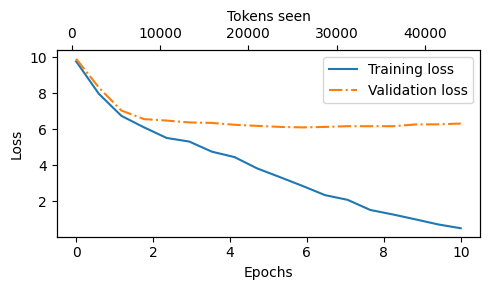

In [108]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

Save the model in order to not execute the training everytime (computational advantage) such that even if the session is closed the model will be still available. Two options:
1. save the model only -> if we don't perform any additional training (only inference)
2. save the model and the optimizer -> if additional training is performed, the optimizer contains important parameters that are needed in order to have a correct convergence

In [109]:
# # save onyl the model
torch.save(model.state_dict(), "model.pth")

# # save the model and the optimizer
# torch.save({
#     "model_state_dict": model.state_dict(),
#     "optimizer_state_dict": optimizer.state_dict(),
#     },
#     "model_and_optimizer.pth"
# )

Load model (in general this is done in another notebook in order to not run the training again)

In [110]:
checkpoint = torch.load("model.pth", map_location=device)
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(torch.load("model.pth", map_location=device))

# checkpoint = torch.load("model_and_optimizer.pth", map_location=device)
# model = GPTModel(GPT_CONFIG_124M)
# model.load_state_dict(checkpoint["model_state_dict"])
# optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.1)
# optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

# # if we save also the optimizer, this means we want to train it again thus set train state
# model.train();

<ipython-input-110-38373285fd4a>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("model.pth", map_location=device)
<ipython-input-110-38373285fd4a>:

<All keys matched successfully>

## Load pretrained weights of GPT2
Since if the device is computationally limited the training is not effective, it is possible to load the weights of the GPT-2 models obtained during pretraining.

In [111]:
# get gpt_download.py

url = (
    "https://raw.githubusercontent.com/rasbt/"
    "LLMs-from-scratch/main/ch05/"
    "01_main-chapter-code/gpt_download.py"
)
filename = url.split('/')[-1]
urllib.request.urlretrieve(url, filename)

('gpt_download.py', <http.client.HTTPMessage at 0x7e0407dacfd0>)

Load GPT-2 architecture settings and parameters

In [112]:
from gpt_download import download_and_load_gpt2
settings, params = download_and_load_gpt2(model_size="124M", models_dir="gpt2")

File already exists and is up-to-date: gpt2/124M/checkpoint
File already exists and is up-to-date: gpt2/124M/encoder.json
File already exists and is up-to-date: gpt2/124M/hparams.json
File already exists and is up-to-date: gpt2/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/124M/model.ckpt.index
File already exists and is up-to-date: gpt2/124M/model.ckpt.meta
File already exists and is up-to-date: gpt2/124M/vocab.bpe


In [113]:
print("Settings:", settings)
print("Parameter dictionary keys:", params.keys())

Settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}
Parameter dictionary keys: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])


All configurations for GPT-2 models (small, medium, large, xl)

In [114]:
model_configs = {
  "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
  "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
  "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
  "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

Update our previous config ('GPT_CONFIG_124M') with new parameters

In [115]:
model_name = "gpt2-small (124M)"
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])

NEW_CONFIG.update({"context_length": 1024})
# not used anymore but need to match the settings employed
NEW_CONFIG.update({"qkv_bias": True})

create new GPT instance with new parameters, however the initial weights are random

In [116]:
gpt = GPTModel(NEW_CONFIG)
gpt.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

Function to check that left and right tensors have same shape (check if assignment of data is correct)

In [117]:
def assign(left, right):
  if left.shape != right.shape:
    raise ValueError(f"Shape mismatch. Left: {left.shape}, " "Right: {right.shape}")
  return torch.nn.Parameter(torch.tensor(right))

Assign loaded parameters to the new model with the new configuration. Complex function and based on some guessing since GPT used different names. It is possible to load the pretrained GPT model without manually assign all parameters, but this is for demonstration purpose (i.e. model = GPT2Model.from_pretrained("gpt2"))

In [118]:
def load_weights_into_gpt(gpt, params):
  # assign positional and token embeddings
  gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
  gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])

  # iteration over all transformer blocks
  for b in range(len(params["blocks"])):
    # query, key and value components for self attention mechanism
    # split concatenated weights for q,k,v into 3 components q_w, k_w, v_w, transpose and assign
    q_w, k_w, v_w = np.split(
        (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
    gpt.trf_blocks[b].att.W_query.weight = assign(
        gpt.trf_blocks[b].att.W_query.weight, q_w.T)
    gpt.trf_blocks[b].att.W_key.weight = assign(
        gpt.trf_blocks[b].att.W_key.weight, k_w.T)
    gpt.trf_blocks[b].att.W_value.weight = assign(
        gpt.trf_blocks[b].att.W_value.weight, v_w.T)

    # same for biases
    q_b, k_b, v_b = np.split(
        (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
    gpt.trf_blocks[b].att.W_query.bias = assign(
        gpt.trf_blocks[b].att.W_query.bias, q_b)
    gpt.trf_blocks[b].att.W_key.bias = assign(
        gpt.trf_blocks[b].att.W_key.bias, k_b)
    gpt.trf_blocks[b].att.W_value.bias = assign(
        gpt.trf_blocks[b].att.W_value.bias, v_b)

    # output projection
    gpt.trf_blocks[b].att.out_proj.weight = assign(
        gpt.trf_blocks[b].att.out_proj.weight, params["blocks"][b]["attn"]["c_proj"]["w"].T)
    gpt.trf_blocks[b].att.out_proj.bias = assign(
        gpt.trf_blocks[b].att.out_proj.bias, params["blocks"][b]["attn"]["c_proj"]["b"])

    # feedforward nn
    gpt.trf_blocks[b].ff.layers[0].weight = assign(
        gpt.trf_blocks[b].ff.layers[0].weight, params["blocks"][b]["mlp"]["c_fc"]["w"].T)
    gpt.trf_blocks[b].ff.layers[0].bias = assign(
        gpt.trf_blocks[b].ff.layers[0].bias, params["blocks"][b]["mlp"]["c_fc"]["b"])
    gpt.trf_blocks[b].ff.layers[2].weight = assign(
        gpt.trf_blocks[b].ff.layers[2].weight, params["blocks"][b]["mlp"]["c_proj"]["w"].T)
    gpt.trf_blocks[b].ff.layers[2].bias = assign(
        gpt.trf_blocks[b].ff.layers[2].bias, params["blocks"][b]["mlp"]["c_proj"]["b"])

    # layer normalization, where scale='g' for gain and shift='b' for bias
    gpt.trf_blocks[b].norm1.scale = assign(
        gpt.trf_blocks[b].norm1.scale, params["blocks"][b]["ln_1"]["g"])
    gpt.trf_blocks[b].norm1.shift = assign(
        gpt.trf_blocks[b].norm1.shift, params["blocks"][b]["ln_1"]["b"])
    gpt.trf_blocks[b].norm2.scale = assign(
        gpt.trf_blocks[b].norm2.scale, params["blocks"][b]["ln_2"]["g"])
    gpt.trf_blocks[b].norm2.shift = assign(
        gpt.trf_blocks[b].norm2.shift, params["blocks"][b]["ln_2"]["b"])

  # final layer normalization and output head
  gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
  gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
  gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])

In [119]:
load_weights_into_gpt(gpt, params)
gpt.to(device)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

Use model with loaded parameters to see token prediction and check that output text is coherent.

In [120]:
torch.manual_seed(123)
token_ids = generate(
model=gpt,
idx=text_to_token_ids("Every effort moves you", tokenizer).to(device), max_new_tokens=25,
context_size=NEW_CONFIG["context_length"],
top_k=50,
temperature=1.5
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you toward an equal share for each vote plus half. Inequality is often not an accurate representation of human worth; to know the


# Fine-tuning for classification (spam detection)
In general LLMs are not used for tasks such as spam detection, however this is for demonstration purposes with a simple task.

After the pretraining where the model learns how to perdict next tokens in a coherent way, LLMs can be fine-tuned to perform required task such as classification, question answering, sentiment analysis, text generation, etc. The fine-tuning can be divided into:
1. fine-tuning for classification: perform classification given an input such as spam detection, element recognition given images (tumors, object detection), text classification, etc. More specific than other fine-tuning since it is specialized in performing only the classification it saw only during the training phase

2. fine-tuning to follow instruction: fine-tune model such that given some instructions (in form of prompts) in natural language it is able to understand and execute the required different tasks. E.g. "**Translate in German** 'text to translate' ". Can perform different tasks

## Dataset preprocessing

Download dataset for spam detection

In [121]:
url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
# name of downloaded file
zip_path = "sms_spam_collection.zip"
# where the unzipped file is stored
extracted_path = "sms_spam_collection"
# create path pointing to sms_spam_collection appending SMSSpamCollection to the path -> after the unzip the dataset will be called SMSSpamCollection.tsv
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"

tokenizer = tiktoken.get_encoding("gpt2")

In [122]:
def download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path):
  if data_file_path.exists():
    print(f"{data_file_path} already exists. Skipping download and extraction.")
    return
  # download file (write in zip_path the file read from url contained in 'response')
  with urllib.request.urlopen(url) as response:
    with open(zip_path, "wb") as out_file:
        out_file.write(response.read())
  # unzip file
  with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(extracted_path)
  # add .tsv file extension
  original_file_path = Path(extracted_path) / "SMSSpamCollection"
  # add .tsv extension
  os.rename(original_file_path, data_file_path)
  print(f"File downloaded and saved as {data_file_path}")


In [123]:
download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)

sms_spam_collection/SMSSpamCollection.tsv already exists. Skipping download and extraction.


Load .tsv file in a dataframe

In [124]:
# /t since it it tab-separated (TSV) to know how to separate columns
df = pd.read_csv(data_file_path, sep="\t", header=None, names=["Label", "Text"] )
df

,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [125]:
print(df["Label"].value_counts())

Label
ham     4825
spam     747
Name: count, dtype: int64


Simple dataset balancing since the two classes 'spam' and 'ham' have very different sizes -> done to avoid class bias and improve generalization (not performant with the small classes)

In [126]:
def create_balanced_dataset(df):
  num_spam = df[df["Label"] == 'spam'].shape[0]
  # sample randomly num_spam number of ham data to balance the two classes. Ensure reproducibility with random_state
  ham_subset = df[df["Label"] == 'ham'].sample(num_spam, random_state=123)
  # concatenate new column of the ham subset with all spam
  balanced_df = pd.concat([ham_subset, df[df["Label"] == "spam"]])
  return balanced_df

In [127]:
balanced_df = create_balanced_dataset(df)
print(balanced_df["Label"].value_counts())

Label
ham     747
spam    747
Name: count, dtype: int64


Convert labels into integers 0 and 1

In [128]:
balanced_df["Label"] = balanced_df["Label"].map({"ham": 0, "spam": 1})

Split data in dataset randomly in training set (70%), validation set (10%), test set (20%)

In [129]:
def random_split(df, train_frac, validation_frac):
  # sample randomly data, since we take frac=1, we simply shuffle them. Drop old indices and reset them
  df = df.sample(frac=1, random_state=123).reset_index(drop=True)
  # get indices of split
  train_end = int(len(df) * train_frac)
  validation_end = train_end + int(len(df) * validation_frac)

  train_df = df[:train_end]
  validation_df = df[train_end:validation_end]
  test_df = df[validation_end:]

  return train_df, validation_df, test_df


In [130]:
train_df, validation_df, test_df = random_split(balanced_df, 0.7, 0.1)

Save datasets as CSV

In [131]:
train_df.to_csv("train.csv", index=None)
validation_df.to_csv("validation.csv", index=None)
test_df.to_csv("test.csv", index=None)

Create data loaders -> for the pretraining we had a sliding window that permit to had sentences of the same length, but in emails the lengths are different, thus:
1. truncate all messages to the length of the shortest one -> cheaper but there is the possibility of information loss if the shortest message is really short

2. add padding to all messages reaching the length of the longest one -> expensive but preserve information -> in this case we use this option with "<|endoftext|>" as padding token


In [132]:
class SpamDataset(Dataset):
  def __init__(self, csv_file, tokenizer, max_length=None, pad_token_id=50256):
    self.data = pd.read_csv(csv_file)
    self.encoded_texts = [tokenizer.encode(text) for text in self.data["Text"]]
    if max_length is None:
      self.max_length = self._longest_encoded_length()
    else:
      self.max_length = max_length
    self.encoded_texts = [encoded_text[:self.max_length]for encoded_text in self.encoded_texts]
    self.encoded_texts = [encoded_text + [pad_token_id] *(self.max_length - len(encoded_text))for encoded_text in self.encoded_texts]

  def __getitem__(self, index):
    encoded = self.encoded_texts[index]
    label = self.data.iloc[index]["Label"]
    return (torch.tensor(encoded, dtype=torch.long), torch.tensor(label, dtype=torch.long))

  def __len__(self):
    return len(self.data)

  def _longest_encoded_length(self):
    max_length = 0
    for encoded_text in self.encoded_texts:
      encoded_length = len(encoded_text)
      if encoded_length > max_length:
        max_length = encoded_length
    return max_length


Pad train, test and validation sets

In [133]:
train_dataset = SpamDataset(
    csv_file="train.csv",
    max_length=None,
    tokenizer=tokenizer
)

In [134]:
val_dataset = SpamDataset(
    csv_file="validation.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)

In [135]:
test_dataset = SpamDataset(
    csv_file="test.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)

In [136]:
print(train_dataset.max_length)

120


Generate data loader -> each batch contains 8 input, where an input is an email text of 120 tokens and the label is 0 or 1 depending if spam or not

In [137]:
num_workers = 0
batch_size = 8
torch.manual_seed(123)

In [138]:
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
)

In [139]:
val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

In [140]:
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

Check batch sizes if correct

In [141]:
for input_batch, target_batch in train_loader:
  pass
print("Input batch dimensions:", input_batch.shape)
print("Label batch dimensions", target_batch.shape)

Input batch dimensions: torch.Size([8, 120])
Label batch dimensions torch.Size([8])


Print total batches in each set

In [142]:
print(f"{len(train_loader)} training batches")
print(f"{len(val_loader)} validation batches")
print(f"{len(test_loader)} test batches")

130 training batches
19 validation batches
38 test batches


## Model setup

### Model initialization

Same configuration as for unlabeled data

In [143]:
CHOOSE_MODEL = "gpt2-small (124M)"
INPUT_PROMPT = "Every effort moves"

In [144]:
BASE_CONFIG = {
    "vocab_size": 50257,
    "context_length": 1024,
    "drop_rate": 0.0,
    "qkv_bias": True
}

In [145]:
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

In [146]:
BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

Download weights into gpt-2 model

In [147]:
model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(model_size=model_size, models_dir="gpt2")
model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval()

File already exists and is up-to-date: gpt2/124M/checkpoint
File already exists and is up-to-date: gpt2/124M/encoder.json
File already exists and is up-to-date: gpt2/124M/hparams.json
File already exists and is up-to-date: gpt2/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/124M/model.ckpt.index
File already exists and is up-to-date: gpt2/124M/model.ckpt.meta
File already exists and is up-to-date: gpt2/124M/vocab.bpe


GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

Check if model outputs coherent text, thus the parameters has been loaded correctly

In [148]:
text_1 = "Every effort moves you"

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_1, tokenizer),
    max_new_tokens=15,
    context_size=BASE_CONFIG["context_length"]
)
print(token_ids_to_text(token_ids, tokenizer))

Every effort moves you forward.

The first step is to understand the importance of your work


### Classification head
Substitute the original output layer that maps to the vocabulary ('out_head') with a smaller output layer that maps to two classes only: 0 and 1 (not spam or spam). Without fine-tuning, with the new output layer the output of the model will be (batch_size, nr_tokens, vocab_dim), but the vocab_dim instead of being 50257 is now 2 (embedding dim) (for prediction of next token we take into consideration only the last token of the output).

We freeze the model for the fine-tuning in order to not update the parameters -> keep the pre-trained weights intact and only train the new layers or the final layer to adapt the model to a new task or dataset

In [149]:
for param in model.parameters():
  param.requires_grad = False

Change final layer. This one has requires_grad = True automatically, thus this will be the only layer updated during fine-tuning. However despite the fact this should be sufficient, by empirical experiments fine-tuning additional layers improve the performance of the model

In [150]:
torch.manual_seed(123)
num_classes = 2

model.out_head = torch.nn.Linear(
    # = 768, output dimension of transformer blocks
    in_features = BASE_CONFIG["emb_dim"],
    out_features = num_classes,
)

Make trainable last transformer block and final LayerNorm

In [151]:
for param in model.trf_blocks[-1].parameters():
    param.requires_grad = True

for param in model.final_norm.parameters():
    param.requires_grad = True

Consider only last token of the output for the classification. Why? Given the implementation of the attention mask that permit each token to have information about all preceeding tokens in the sequence, the last one is the one with most information. Using the softmax on these two values for each input text we get the probability to be spam or not spam, and we take the highest one as the correct class

### Implement evaluation utilities
Compute classification loss and model accuracy (percentage of correct predictions)

In [152]:
def calc_accuracy_loader(data_loader, model, device, num_batches=None):
  model.eval()
  correct_predictions, num_examples = 0, 0
  if num_batches is None:
    num_batches = len(data_loader)
  else:
      num_batches = min(num_batches, len(data_loader))

  for i, (input_batch, target_batch) in enumerate(data_loader):
    if i < num_batches:
      input_batch = input_batch.to(device)
      target_batch = target_batch.to(device)

      with torch.no_grad():
        logits = model(input_batch)[:, -1, :]
      predicted_labels = torch.argmax(logits, dim=-1)
      num_examples += predicted_labels.shape[0]

      correct_predictions += ((predicted_labels == target_batch).sum().item())
    else:
      break
  return correct_predictions / num_examples

function loss: cross-entropy for a single batch

In [153]:
def calc_loss_batch(input_batch, target_batch, model, device):
  input_batch = input_batch.to(device)
  target_batch = target_batch.to(device)
  logits = model(input_batch)[:, -1, :]
  loss = torch.nn.functional.cross_entropy(logits, target_batch)
  return loss

loss for all batches

In [154]:
def calc_loss_loader(data_loader, model, device, num_batches=None):
  total_loss = 0.
  if len(data_loader) == 0:
    return float("nan")
  elif num_batches is None:
    num_batches = len(data_loader)
  else:
    num_batches = min(num_batches, len(data_loader))
  for i, (input_batch, target_batch) in enumerate(data_loader):
    if i < num_batches:
      loss = calc_loss_batch(input_batch, target_batch, model, device)
      total_loss += loss.item()
    else:
      break
  return total_loss / num_batches

Initial loss

In [155]:
with torch.no_grad():
  train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)

val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)
test_loss = calc_loss_loader(test_loader, model, device, num_batches=5)

print(f"Training loss: {train_loss:.3f}")
print(f"Validation loss: {val_loss:.3f}")
print(f"Test loss: {test_loss:.3f}")

Training loss: 2.183
Validation loss: 2.583
Test loss: 2.322


## Model fine-tuning and usage

In [156]:
def train_classifier_simple(model, train_loader, val_loader, optimizer, device,num_epochs, eval_freq, eval_iter):
  train_losses, val_losses, train_accs, val_accs = [], [], [], []
  examples_seen, global_step = 0, -1
  for epoch in range(num_epochs):
    model.train()
    for input_batch, target_batch in train_loader:
      optimizer.zero_grad()
      loss = calc_loss_batch(input_batch, target_batch, model, device)
      loss.backward()
      optimizer.step()

      examples_seen += input_batch.shape[0]
      global_step += 1

      if global_step % eval_freq == 0:
        train_loss, val_loss = evaluate_model(model, train_loader, val_loader, device, eval_iter)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        print(f"Ep {epoch+1} (Step {global_step:06d}): "
              f"Train loss {train_loss:.3f}, "
              f"Val loss {val_loss:.3f}")

    train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=eval_iter)
    val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=eval_iter)

    print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
    print(f"Validation accuracy: {val_accuracy*100:.2f}%")
    train_accs.append(train_accuracy)
    val_accs.append(val_accuracy)
  return train_losses, val_losses, train_accs, val_accs, examples_seen


Run fine-tuning computing the time needed

In [157]:
start_time = time.time()
torch.manual_seed(123)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)
num_epochs = 5

In [158]:
train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
        model, train_loader, val_loader, optimizer, device,
        num_epochs=num_epochs, eval_freq=50,
        eval_iter=5
)

end_time = time.time()
execution_time_minutes = (end_time - start_time)/60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 2.153, Val loss 2.392
Ep 1 (Step 000050): Train loss 0.617, Val loss 0.637
Ep 1 (Step 000100): Train loss 0.523, Val loss 0.557
Training accuracy: 70.00% | Validation accuracy: 72.50%
Ep 2 (Step 000150): Train loss 0.561, Val loss 0.489
Ep 2 (Step 000200): Train loss 0.419, Val loss 0.397
Ep 2 (Step 000250): Train loss 0.409, Val loss 0.353
Training accuracy: 82.50% | Validation accuracy: 85.00%
Ep 3 (Step 000300): Train loss 0.333, Val loss 0.320
Ep 3 (Step 000350): Train loss 0.340, Val loss 0.306
Training accuracy: 90.00% | Validation accuracy: 90.00%
Ep 4 (Step 000400): Train loss 0.136, Val loss 0.200
Ep 4 (Step 000450): Train loss 0.153, Val loss 0.132
Ep 4 (Step 000500): Train loss 0.222, Val loss 0.137
Training accuracy: 100.00% | Validation accuracy: 97.50%
Ep 5 (Step 000550): Train loss 0.207, Val loss 0.143
Ep 5 (Step 000600): Train loss 0.083, Val loss 0.074
Training accuracy: 100.00% | Validation accuracy: 97.50%
Training completed in 60.24 m

In [159]:
def plot_values(epochs_seen, examples_seen, train_values, val_values, label="loss"):
  fig, ax1 = plt.subplots(figsize=(5, 3))
  # plot training and validation values with respect to epochs
  ax1.plot(epochs_seen, train_values, label=f"Training {label}")
  ax1.plot(epochs_seen, val_values, label=f"Validation {label}")
  ax1.set_xlabel("Epoch")
  ax1.set_ylabel(label.capitalize())
  ax1.legend()

  # create new x-axis on same plot that overlay x1 but without interfere
  ax2 = ax1.twiny()
  ax2.plot(examples_seen, train_values, alpha=0)
  ax2.set_xlabel("Examples seen")

  # adjust layout to avoid overlap between plot elements
  fig.tight_layout()
  # store plot
  plt.savefig(f"{label}-plot.pdf")
  plt.show()

Plot classification loss

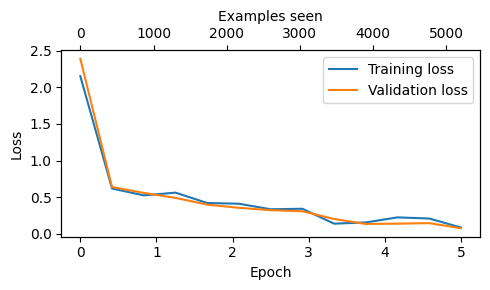

In [160]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))
plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

Plot classification accuracy

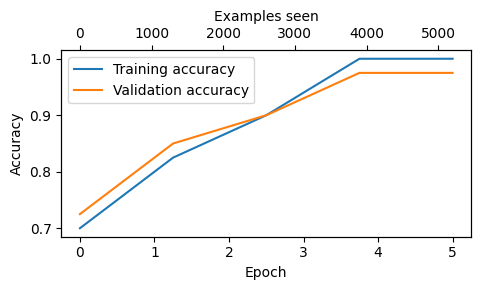

In [161]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_accs))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_accs))
plot_values(epochs_tensor, examples_seen_tensor, train_accs, val_accs, label="accuracy")

Compute accuracy of entire datasets

In [162]:
train_accuracy = calc_accuracy_loader(train_loader, model, device)
val_accuracy = calc_accuracy_loader(val_loader, model, device)
test_accuracy = calc_accuracy_loader(test_loader, model, device)

In [163]:
print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 97.21%
Validation accuracy: 97.32%
Test accuracy: 95.67%


Use model for email classification with new data

In [164]:
def classify_review(text, model, tokenizer, device, max_length=None, pad_token_id=50256):
  model.eval()
  input_ids = tokenizer.encode(text)
  # gives the maximum sequence length that can be processed by the model (the one chosen as maximum length for the fine-tuning)
  supported_context_length = model.pos_emb.weight.shape[1]
  # truncate text if needed
  input_ids = input_ids[:min(max_length, supported_context_length)]
  # add padding
  input_ids += [pad_token_id] * (max_length - len(input_ids))

  input_tensor = torch.tensor(input_ids, device=device).unsqueeze(0)

  with torch.no_grad():
    # get last token with all information
    logits = model(input_tensor)[:, -1, :]
  # get value (0,1) associated with highest probability of last token
  predicted_label = torch.argmax(logits, dim=-1).item()

  return "spam" if predicted_label == 1 else "not spam"


Check prediction

In [165]:
text_1 = (
    "You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award."
)

text_2 = (
    "Hey, just wanted to check if we're still on"
    " for dinner tonight? Let me know!"
)

In [166]:
print(classify_review(text_1, model, tokenizer, device, max_length= train_dataset.max_length))
print(classify_review(text_2, model, tokenizer, device, max_length=train_dataset.max_length))

spam
not spam


Save the model

In [167]:
torch.save(model.state_dict(), "review_classifier.pth")

# Fine-tuning to follow instruction
The model should be able to understand a given instruction as prompt and get a correct answer.

## Dataset preprocessing

The dataset consists of 1,100 instruction–response pairs

In [168]:
def download_and_load_file(file_path, url):
  # if not already downloaded
    if not os.path.exists(file_path):
        with urllib.request.urlopen(url) as response:
            text_data = response.read().decode("utf-8")
        with open(file_path, "w", encoding="utf-8") as file:
            file.write(text_data)
    # otherwise read only
    else:
        with open(file_path, "r", encoding="utf-8") as file:
            text_data = file.read()
    with open(file_path, "r") as file:
        data = json.load(file)
    return data

In [169]:
file_path = "instruction-data.json"
url = ("https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch07/01_main-chapter-code/instruction-data.json")
data = download_and_load_file(file_path, url)
print("Number of entries:", len(data))

Number of entries: 1100


Get structure of data, composed by 'instruction', 'input' and 'output', however 'input' is not always present, e.g. {'instruction': "What is an antonym of 'complicated'?", 'input': '', 'output': "An antonym of 'complicated' is 'simple'."}

In [170]:
print("Example entry:\n", data[50])
print("Example entry:\n", data[599])

Example entry:
 {'instruction': 'Identify the correct spelling of the following word.', 'input': 'Ocassion', 'output': "The correct spelling is 'Occasion.'"}
Example entry:
 {'instruction': 'Create a new sentence by combining the two sentences.', 'input': 'He likes to swim. He goes to the pool every day.', 'output': 'He likes to swim and goes to the pool every day.'}


Two methods to format the entries for the LLM:
1. **Alpaca prompt style**

  "Below is an instruction that
  describes a task. Write a response
  that appropriately completes the
  request.

  \### Instruction:

  Identify the correct spelling of the
  following word.

  \### Input:

  Ocassion

  \### Response:

  The correct spelling is 'Occasion'."

2. **Phi-3 prompt style**

  "<|user|>

  Identify the correct spelling of the
  following word: 'Ocassion'

  <|assistant|>

  The correct spelling is 'Occasion'."

Convert entries in Alpaca format

In [171]:
def format_input(entry):
  instruction_text = (
      f"Below is an instruction that describes a task. "
      f"Write a response that appropriately completes the request."
      f"\n\n### Instruction:\n{entry['instruction']}"
  )

  input_text = (
      f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""
  )

  return instruction_text + input_text

Check format

In [172]:
model_input = format_input(data[50])
desired_response = f"\n\n### Response:\n{data[50]['output']}"
print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Identify the correct spelling of the following word.

### Input:
Ocassion

### Response:
The correct spelling is 'Occasion.'


Split dataset into train (85%), test(10%) and validation set(5%)

In [173]:
train_portion = int(len(data) * 0.85)
test_portion = int(len(data) * 0.1)
val_portion = len(data) - train_portion - test_portion

train_data = data[:train_portion]
test_data = data[train_portion:train_portion + test_portion]
val_data = data[train_portion + test_portion:]

print("Train set size:", len(train_data))
print("Test set size:", len(test_data))
print("Val set size:", len(val_data))

Train set size: 935
Test set size: 110
Val set size: 55


Organize data into batches.
Steps:
1. Format data using prompt template -> Format input into an instruction- response template.

2. Tokenize formatted data -> Convert instruction-response entry into token IDs.
3. Adjust to the same length with padding tokens -> Add end-of-text tokens (50256) to pad data samples to the same length.

4. Create target token IDs for training -> Create a list of target token IDs for the model to learn (these are the inputs shifted by 1, plus an additional padding token).

5. Replace padding tokens with placeholders (masking for ignoring) -> Replace certain padding tokens by -100 to exclude them from the training loss. Another possibility in addition is to mask the input instruction (instruction + input) replacing the IDs with -100 leaving the response only in order to reduce overfitting , but this has been proven to reduce performance

Previsouly the collate function (how data are combined in the batches) was implemented automatically by Pytorch in the class DataLoader, however for instruction fine-tuning we had to create it on our own

Step 1 and 2

Configure dataset in correct format and encode

In [174]:
class InstructionDataset(Dataset):
  def __init__(self, data, tokenizer):
    self.data = data
    self.encoded_texts = []
    for entry in data:
      instruction_plus_input = format_input(entry)
      response_text = f"\n\n### Response:\n{entry['output']}"
      full_text = instruction_plus_input + response_text
      self.encoded_texts.append(tokenizer.encode(full_text))

  def __getitem__(self, index):
      return self.encoded_texts[index]

  def __len__(self):
      return len(self.data)

Step 3 -> use a custom collate function such that each input in the batch has same length adding a padding ID 50256 corresponding to the tag '<|endoftext|>', however the length of the inputs in each batch can vary in order to avoid adding too much padding (the padding added depends on the longest sequence in the current batch):

**Batch 1**

input 1 [1,2,3,4,5] -> input 1 [1,2,3,4,5]

input 2 [1,2,3] -> input 2 [1,2,3,50256,50256]

input 3 [1,2] -> input 3 [1,2,50256,50256,50256]


**Batch 2**

input 1 [1,2] -> input 1 [1,2,50256]

input 2 [1,2,3] -> input 2 [1,2,3]

input 3 [1] -> input 3 [1,50256,50256]

In [175]:
# get single batch as input
def custom_collate_draft_1(batch,pad_token_id=50256,device="cpu"):
  # max length sequence for each batch
  batch_max_length = max(len(item)+1 for item in batch)
  inputs_lst = []

  for item in batch:
    new_item = item.copy()
    new_item += [pad_token_id]

    padded = (new_item + [pad_token_id] *(batch_max_length - len(new_item)))
    inputs = torch.tensor(padded[:-1])
    inputs_lst.append(inputs)

  # convert list of inputs to tensor
  inputs_tensor = torch.stack(inputs_lst).to(device)
  return inputs_tensor

In [176]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]
batch = (
    inputs_1,
    inputs_2,
    inputs_3
)
print(custom_collate_draft_1(batch))

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])


Step 4

Collate function updated to generate target token ID, that are the inputs shifted by 1 as in the pretraining -> in this way the model is able to generate coherent tokens and follow its flow since the structure of instruction, input and response is given in the input, i.e.

Input:    Translate 'hello' into Spanish:

Target:   Translate 'hello' into Spanish: hola

In our case since the inputs are padded, the target is the input sequence without the first token, and with an additional 50256 ID at the end (end tag). Despite the fact there is not an actual text token, the model is able to understand the relationship between tokens and how to generate coherent next token to follow instructions.

In [177]:
def custom_collate_draft_2(batch,pad_token_id=50256,device="cpu"):
  batch_max_length = max(len(item)+1 for item in batch)
  inputs_lst, targets_lst = [], []
  for item in batch:
    new_item = item.copy()
    new_item += [pad_token_id]

  padded = (new_item + [pad_token_id] *(batch_max_length - len(new_item)))
  inputs = torch.tensor(padded[:-1])
  targets = torch.tensor(padded[1:])
  inputs_lst.append(inputs)
  targets_lst.append(targets)
  inputs_tensor = torch.stack(inputs_lst).to(device)
  targets_tensor = torch.stack(targets_lst).to(device)
  return inputs_tensor, targets_tensor

In [178]:
inputs, targets = custom_collate_draft_2(batch)
print(inputs)
print(targets)

tensor([[    7,     8,     9, 50256, 50256]])
tensor([[    8,     9, 50256, 50256, 50256]])


Step 5

Substitute all 50256 IDs with -100 (masking out padding tokens -> value ignored by the cross-entropy loss because by implementation it ignores targets labeled -100) but not the last one, since in this way the model is able to learn when the response should be terminated. This process is not performed in the fine-tuning for classification since we train only on the last output token

In [179]:
def custom_collate_fn(batch,pad_token_id=50256,ignore_index=-100,allowed_max_length=None,device="cpu"):
  batch_max_length = max(len(item)+1 for item in batch)
  inputs_lst, targets_lst = [], []
  for item in batch:
      new_item = item.copy()
      new_item += [pad_token_id]

      padded = (new_item + [pad_token_id] *(batch_max_length - len(new_item)))
      inputs = torch.tensor(padded[:-1])
      targets = torch.tensor(padded[1:])

      # create a mask where padding tokens are `True`, e.g. mask = tensor([False, False, False, True, True, True])
      mask = targets == pad_token_id
      # find indices of the padding tokens, e.g. indices = tensor([3,4,5])
      indices = torch.nonzero(mask).squeeze()
      # check if more than one pad_token_id
      if indices.numel() > 1:
        # set all but not first pad token to -100
        targets[indices[1:]] = ignore_index

      # truncate if max length given
      if allowed_max_length is not None:
        inputs = inputs[:allowed_max_length]
        targets = targets[:allowed_max_length]

      inputs_lst.append(inputs)
      targets_lst.append(targets)

  inputs_tensor = torch.stack(inputs_lst).to(device)
  targets_tensor = torch.stack(targets_lst).to(device)
  return inputs_tensor, targets_tensor

In [180]:
inputs, targets = custom_collate_fn(batch)
print(inputs)
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256,  -100,  -100,  -100],
        [    8,     9, 50256,  -100,  -100]])


In [181]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Create new function based on customized_collate_fn with some pre-defined parameters that will be freezed

In [182]:
customized_collate_fn = partial(
    custom_collate_fn,
    device=device,
    allowed_max_length=1024
)

Data loader

In [183]:
num_workers = 0
batch_size = 8
torch.manual_seed(123)

In [184]:
train_dataset = InstructionDataset(train_data, tokenizer)
val_dataset = InstructionDataset(val_data, tokenizer)
test_dataset = InstructionDataset(test_data, tokenizer)

In [185]:
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

Check sizes (dimensions 1 are different in batches because of the custom collate function for padding)

In [186]:
print("Train loader:")
i = 0
for inputs, targets in train_loader:
  # if i < 10:
    print(inputs.shape, targets.shape)
  # i+=1

Train loader:
torch.Size([8, 61]) torch.Size([8, 61])
torch.Size([8, 76]) torch.Size([8, 76])
torch.Size([8, 73]) torch.Size([8, 73])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 72]) torch.Size([8, 72])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 75]) torch.Size([8, 75])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 77]) torch.Size([8, 77])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 79]) torch.Size([8, 79])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 66]) torch.Size([8, 66])
torch.Size([8, 83]) torch.Size([8, 83])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 68]) torch.

## Fine-tuning

Load pretrained medium GPT model for better performance

In [187]:
CHOOSE_MODEL = "gpt2-medium (355M)"
BASE_CONFIG.update(model_configs[CHOOSE_MODEL])
model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(model_size=model_size,models_dir="gpt2")

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();

File already exists and is up-to-date: gpt2/355M/checkpoint
File already exists and is up-to-date: gpt2/355M/encoder.json
File already exists and is up-to-date: gpt2/355M/hparams.json
File already exists and is up-to-date: gpt2/355M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/355M/model.ckpt.index
File already exists and is up-to-date: gpt2/355M/model.ckpt.meta
File already exists and is up-to-date: gpt2/355M/vocab.bpe


Compute initial loss

In [188]:
model.to(device)
torch.manual_seed(123)
with torch.no_grad():
  train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
  val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)
print("Training loss:", train_loss)
print("Validation loss:", val_loss)

RuntimeError: 0D or 1D target tensor expected, multi-target not supported

Fine-tuning

In [ ]:
start_time = time.time()
torch.manual_seed(123)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005, weight_decay=0.1)
num_epochs = 2
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context=format_input(val_data[0]), tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Plot train and validation losses

In [ ]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

## LLM evaluation